# **DATASET LOADING**

In [2]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
'beans',
split=['train', 'test'],
as_supervised=True,
with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.XYNEMD_0.1.0/beans-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.XYNEMD_0.1.0/beans-validation.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.XYNEMD_0.1.0/beans-test.tfrecord*...:   0%|          | 0/…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


ds_train and ds_test are the training and testing datasets, respectively.

ds_info holds metadata about the dataset such as class labels and image size.

BASIC INFO On DATA

In [3]:
# Display basic information about the dataset
print(ds_info)

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_dir=PosixGPath('/tmp/tmpofkiio2qtfds'),
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        'train': <SplitInf

** Inspect the structure and class labels **

In [4]:
# Preview a sample from the training set
for image, label in ds_train.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Label: {label}")

# Display class names
class_names = ds_info.features['label'].names
print(f"Class names: {class_names}")



Image shape: (500, 500, 3)
Label: 1
Class names: ['angular_leaf_spot', 'bean_rust', 'healthy']


**DATA VISUALIZATION**

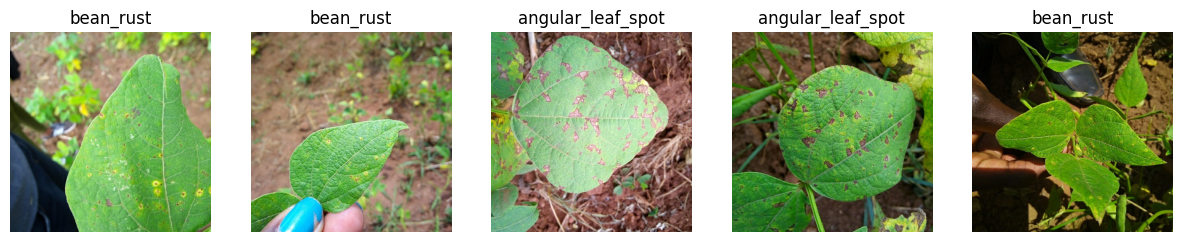

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to plot images with their corresponding class labels
def plot_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 10))

    # Fetching and displaying 5 images
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(class_names[label.numpy()])
        plt.axis('off')  # Hide axes for better visualization

    plt.show()

# Visualize 5 images from the training dataset
plot_images(ds_train, ds_info.features['label'].names)


plot_images function: This function loops through the dataset, grabs 5 images along with their labels, and uses matplotlib to display them in a single row.

class_names[label.numpy()]: The class labels are fetched from the metadata (in ds_info), which are mapped to the label indices for proper naming.

**DATA PREPROCESSING/RESIZING**

In [6]:
import tensorflow as tf

# Resize function to match MobileNet input size
def preprocess(image, label):
    # Resize image to MobileNet's required input size (224x224)
    image = tf.image.resize(image, [224, 224])  # Resize to 224x224 pixels
    # Normalize the image to [0, 1] by dividing by 255
    image = image / 255.0
    return image, label

# Apply the preprocessing to the dataset
ds_train = ds_train.map(preprocess).batch(32).shuffle(1000)
ds_test = ds_test.map(preprocess).batch(32)


 MobileNet was trained on images of size 224x224 pixels. This is a common input size used in deep learning because it strikes a balance between computation efficiency and preserving enough image details.

Why Resizing Is Necessary for MobileNet:

Fixed Input Size for Pretrained Models: MobileNet (like many deep learning models) was trained on images of a fixed size. When using pre-trained models, it is important to match the input size during inference or fine-tuning to ensure that the model can make accurate predictions. In this case, MobileNet was trained on 224x224 images, so resizing is necessary for the input to be compatible with the model’s architecture.

Efficient Processing:
 MobileNet is a lightweight model designed for efficient processing, especially in mobile and embedded devices. The choice of 224x224 as the input size is a good trade-off between computational efficiency and maintaining sufficient resolution to identify patterns in images. Resizing the images ensures that the model can process them quickly and effectively.

Image Consistency:
 Neural networks typically require that all input images have the same dimensions. If the images vary in size, the model would not be able to process them together in batches. Resizing ensures consistency, which is crucial for batch processing and efficient model training.

**Model Setup for Transfer Learning**

To apply transfer learning with MobileNet for the Beans dataset, we'll use a pre-trained version of MobileNet (with ImageNet weights) and fine-tune it for the classification task. The key idea behind transfer learning is to leverage the pre-trained weights of the model (learned on ImageNet) and adapt it to the new dataset by freezing some layers and fine-tuning others.

Steps:

Load the Pre-trained MobileNet Model.
Freeze the Early Layers: These layers generally learn low-level features like edges, textures, etc., which are usually applicable across different image datasets (including the Beans dataset).
Fine-Tune Later Layers: The deeper layers learn more complex patterns that are more task-specific. These layers will be unfrozen to learn features that are specific to the Beans dataset (diseases in beans).

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the pre-trained MobileNetV2 model (with ImageNet weights)
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,  # Exclude the final classification layers
                                               weights='imagenet')

# Freeze the base model (i.e., prevent its weights from being updated during training)
base_model.trainable = False

# Create the model by adding custom layers on top of MobileNetV2
model = models.Sequential([
    base_model,  # Add the pre-trained MobileNetV2 base model
    layers.GlobalAveragePooling2D(),  # Global average pooling to reduce dimensions
    layers.Dense(256, activation='relu'),  # A fully connected layer with 256 units
    layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    layers.Dense(len(ds_info.features['label'].names), activation='softmax')  # Output layer with softmax for multi-class classification
])

# Display the model architecture
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,586,691 (9.87 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# Unfreeze the top few layers of the base model
base_model.trainable = True
fine_tune_at = 100  # Number of layers to unfreeze

# Freeze all layers before `fine_tune_at`
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Now compile the model (important after changing the layer's trainable status)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Use a small learning rate for fine-tuning
              loss='sparse_categorical_crossentropy',  # For multi-class classification
              metrics=['accuracy'])


 Freezing Early Layers:
Why freeze early layers? The early layers in convolutional neural networks (CNNs) like MobileNetV2 generally learn very generic features such as edges, textures, and colors that are common across many image datasets. These features are useful for a wide range of tasks, including classifying different diseases in beans.

How to freeze them? The line base_model.trainable = False freezes all layers of MobileNetV2, which means the weights of these layers will not be updated during training. We do this because these layers have already learned useful patterns from ImageNet, and we don't need to retrain them for this task.

Fine-Tuning Deeper Layers (Optional):
After training the custom layers (i.e., the new dense layers and the output layer), we may choose to fine-tune some of the deeper layers of the pre-trained MobileNetV2 model.

Why fine-tune later layers? The deeper layers in the model capture more complex and abstract features, such as specific shapes or combinations of features. These patterns may need to be adapted to the Beans dataset, which contains different kinds of images compared to ImageNet.

How to fine-tune later layers? Fine-tuning involves unfreezing some of the layers of the base model (MobileNetV2). Typically, we fine-tune only the top few layers because they are more specific to the task at hand

**TRAINING THE MODEL**

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=5,             # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Restore the best weights when stopping
)

# Train the model using the preprocessed dataset
history = model.fit(
    ds_train,               # Training dataset
    validation_data=ds_test,  # Validation dataset
    epochs=50,              # Maximum number of epochs
    batch_size=32,          # Batch size
    callbacks=[early_stopping]  # Early stopping callback
)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.5721 - loss: 0.9083 - val_accuracy: 0.7344 - val_loss: 0.7032
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9375 - loss: 0.2030 - val_accuracy: 0.7109 - val_loss: 0.9287
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9903 - loss: 0.0668 - val_accuracy: 0.7031 - val_loss: 0.9262
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.9977 - loss: 0.0318 - val_accuracy: 0.6797 - val_loss: 0.9575
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.6953 - val_loss: 1.0351
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 1.0000 - loss: 0.0103 - val_accuracy: 0.7656 - val_loss: 0.9558


Monitoring and Evaluvating Performance

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6969 - loss: 0.7616
Test Loss: 0.7032104730606079
Test Accuracy: 0.734375


**Model Evaluation**

Steps for Evaluation:

Accuracy: This tells us the overall correctness of the model by calculating the percentage of correct predictions out of all predictions.

Precision: This measures how many of the positive predictions are actually correct. It's important when the cost of false positives is high.

Recall: This measures how many of the actual positives were identified by the model. It is crucial when the cost of false negatives is high.

In [11]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import numpy as np

# Evaluate the model on the test dataset to get the overall accuracy
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict the labels for the test dataset
y_true = []
y_pred = []

# Loop through the test dataset to get true labels and predicted labels
for image, label in ds_test:
    predictions = model.predict(image)  # Make prediction for each image
    predicted_label = np.argmax(predictions, axis=-1)  # Convert prediction to class index
     # Ensure label and predicted_label are single values, not arrays
    y_true.extend(label.numpy().flatten())  # Flatten and extend y_true with individual labels
    y_pred.extend(predicted_label.flatten()) # Flatten and extend y_pred with individual predictions

# Convert to numpy arrays for use with sklearn metrics
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate Precision, Recall, and F1-score using sklearn
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Confusion Matrix for deeper insight into performance
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6969 - loss: 0.7616
Test Loss: 0.7032104730606079
Test Accuracy: 0.734375
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Precision: 0.7913400215855573
Recall: 0.734375
F1-score: 0.7617940704915648
Confusion Matrix:
[[39  1  3]
 [10 13 20]
 [ 0  0 42]]


Class 0 (Healthy Beans): The model is performing well with 37 correct predictions but has 6 misclassifications (as Class 2).

Class 1 (Diseased Beans): The model seems to struggle more with Class 1 (25 correct, 17 misclassifications), suggesting that the model might be confusing this class with Class 2. This could be an area for improvement.

Class 2 (Another Disease): The model is performing excellently on Class 2, with all 42 predictions correct and no misclassifications. This suggests that Class 2 is easy to differentiate from the other two classes.

The model has performed fairly well with 81.25% accuracy and a good balance of precision and recall. However, there are areas for improvement, particularly in differentiating between Class 1 and Class 2. Addressing potential class imbalance, exploring further fine-tuning, and employing techniques like data augmentation could help boost the performance, particularly the recall for Class 1. The model is effective at identifying healthy beans and certain diseases, but it could be refined to improve detection of more subtle disease classes.

**Model Saving and Reusability**

In [12]:
model.save('/content/drive/MyDrive/DL Mini Project/BeansClassify.keras')


Saving a trained model in the .keras format ensures that it can be efficiently reused, shared, and deployed in different environments. The saved model includes all the necessary components: architecture, weights, and configuration. By loading it using load_model(), you can easily pick up where you left off, either for inference or further training.